In [1]:
import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
# import ASRE models
cur_dir = os.getcwd()
ASREpy_dir = os.path.join(os.path.dirname(os.path.dirname(cur_dir)))
sys.path.append(ASREpy_dir)
import ASREpy.ground_deformation_models as gdm
import ASREpy
import pandas as pd
from scipy import interpolate
np.set_printoptions(threshold=np.inf)

In [2]:
def prepare_greenfield_disp(val_data_dir, vl, beamX):
    ## Prepare Ux-GF
    # Read Ux-GF and Uz-GF
    dispX_gf_file = os.path.join(val_data_dir, f'FranzaDeJong-'
                        f"VL{str(vl*100).replace('.', 'p')}-Ux-GF.csv")
    dispX_gf = pd.read_csv(dispX_gf_file, header=None)

    dispZ_gf_file = os.path.join(val_data_dir, f'FranzaDeJong-'
                        f"VL{str(vl*100).replace('.', 'p')}-Uz-GF.csv")
    dispZ_gf = pd.read_csv(dispZ_gf_file, header=None)
    # Add the left half of Ux-GF and Uz-GF
    left_half = dispX_gf.copy()
    left_half[0] = -left_half[0]
    left_half[1] = -left_half[1]
    dispX_gf = pd.concat([left_half, dispX_gf])
    dispX_gf = dispX_gf.sort_values(by = 0).reset_index(drop = True)

    left_half = dispZ_gf.copy()
    left_half[0] = -left_half[0]
    dispZ_gf = pd.concat([left_half, dispZ_gf])
    dispZ_gf = dispZ_gf.sort_values(by = 0).reset_index(drop = True)
    # Interpolate the dispX_gf with beamX mesh
    f = interpolate.interp1d(dispX_gf[0], dispX_gf[1], fill_value='extrapolate')
    dispX_gf = f(beamX)

    f = interpolate.interp1d(dispZ_gf[0], dispZ_gf[1], fill_value='extrapolate')
    dispZ_gf = f(beamX)
    return dispX_gf/1000, dispZ_gf/1000

def plot_verification(val_data_dir, frame_id, qz_id, beamX, model, axes, model_el = None):
    
    ## Prepare Ux-GF
    # Read Ux-GF and Uz-GF
    dispX_gf_file = os.path.join(val_data_dir, "FranzaDeJong-VL2p0-Ux-GF.csv")
    dispX_gf = pd.read_csv(dispX_gf_file, header=None)

    dispZ_gf_file = os.path.join(val_data_dir, "FranzaDeJong-VL2p0-Uz-GF.csv")
    dispZ_gf = pd.read_csv(dispZ_gf_file, header=None)

    dispL_asre_file =  os.path.join(val_data_dir, f'{frame_id}_'
                        f"{qz_id}_ux.csv")
    dispL_asre_Franza = pd.read_csv(dispL_asre_file, header=None)

    dispV_asre_file =  os.path.join(val_data_dir, f'{frame_id}_'
                        f"{qz_id}_uz.csv")
    dispV_asre_Franza = pd.read_csv(dispV_asre_file, header=None)

    # Sort the disp in file from left to right
    left_half = dispX_gf.copy()
    left_half[0] = -left_half[0]
    left_half[1] = -left_half[1]
    dispX_gf = pd.concat([left_half, dispX_gf])
    dispX_gf = dispX_gf.sort_values(by = 0).reset_index(drop = True)
    
    left_half = dispZ_gf.copy()
    left_half[0] = -left_half[0]
    dispZ_gf = pd.concat([left_half, dispZ_gf])
    dispZ_gf = dispZ_gf.sort_values(by = 0).reset_index(drop = True)
    
    left_half = dispL_asre_Franza.copy()
    left_half[0] = -left_half[0]
    left_half[1] = -left_half[1]
    dispL_asre_Franza = pd.concat([left_half, dispL_asre_Franza])
    dispL_asre_Franza = dispL_asre_Franza.sort_values(by = 0).reset_index(drop = True)

    left_half = dispV_asre_Franza.copy()
    left_half[0] = -left_half[0]
    dispV_asre_Franza = pd.concat([left_half, dispV_asre_Franza])
    dispV_asre_Franza = dispV_asre_Franza.sort_values(by = 0).reset_index(drop = True)
    # Interpolate the dispX_gf with beamX mesh
    f = interpolate.interp1d(dispX_gf[0], dispX_gf[1], fill_value='extrapolate')
    dispX_gf = f(beamX)

    f = interpolate.interp1d(dispZ_gf[0], dispZ_gf[1], fill_value='extrapolate')
    dispZ_gf = f(beamX)

    f = interpolate.interp1d(dispL_asre_Franza[0], dispL_asre_Franza[1], fill_value='extrapolate')
    dispL_asre_Franza = f(beamX)

    f = interpolate.interp1d(dispV_asre_Franza[0], dispV_asre_Franza[1], fill_value='extrapolate')
    dispV_asre_Franza = f(beamX)
    
    axes[0].plot(beamX, dispX_gf, 'r:', label = 'experiment')
    axes[1].plot(beamX, dispZ_gf, 'r:', label = 'experiment')

    axes[0].plot(beamX, dispL_asre_Franza, 'b', label = 'ASRE_Franza')
    axes[1].plot(beamX, -dispV_asre_Franza, 'b', label = 'ASRE_Franza')
    
    if model_el is not None:
        axes[0].plot(beamX, model.beam_DispL[model.footing_nodes_ind]*1000, 'bx', label = 'ASREpy_ep')
        axes[1].plot(beamX, model.beam_DispV[model.footing_nodes_ind]*1000, 'bx', label = 'ASREpy_ep')

        axes[0].plot(beamX, model_el.beam_DispL[model.footing_nodes_ind]*1000, 'b^', label = 'ASREpy_el')
        axes[1].plot(beamX, model_el.beam_DispV[model.footing_nodes_ind]*1000, 'b^', label = 'ASREpy_el')
    else:
        axes[0].plot(beamX, model.beam_DispL[model.footing_nodes_ind]*1000, 'bx', label = 'ASREpy')
        axes[1].plot(beamX, model.beam_DispV[model.footing_nodes_ind]*1000, 'bx', label = 'ASREpy')


    axes[0].legend()
    axes[1].legend()

    axes[0].set_title(f'{frame_id}, {qz_id}, Ux')
    axes[1].set_title(f'{frame_id}, {qz_id}, Uz')

    axes[0].set_xlim([0, 15])
    axes[1].set_xlim([0, 15])
    axes[0].set_ylim([-60, 36])
    axes[1].set_ylim([-60, 36])
    
val_data_dir = r"VerificationData"

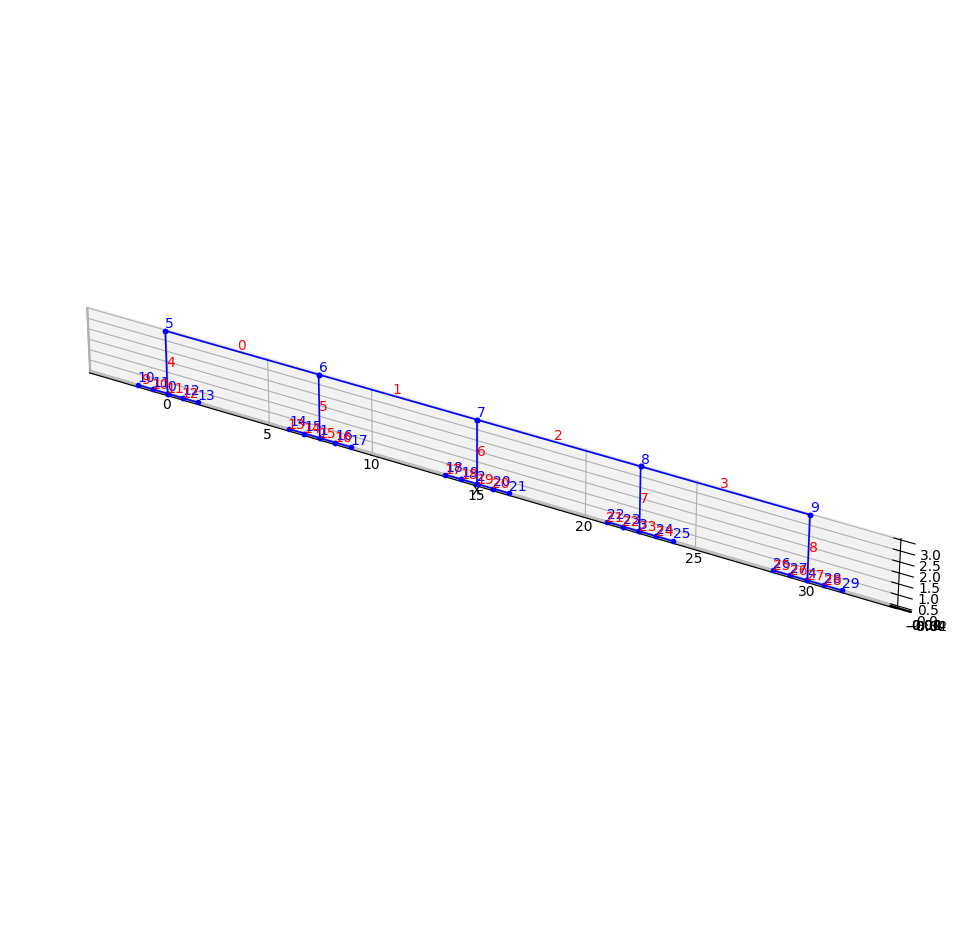

In [3]:
## Create the FR-2c2 model
beam_to_node = {}
# Clear existing model
ops.wipe()

# Define Model Builder
ops.model('basic', '-ndm', 3, '-ndf', 6)  # 3D model with 6 DOF per node

# Define parameters
n_bay = 4        # Number of bays
l_bay = 7.5      # Length of each bay
h_bay = 3.0      # Height of each story
numStories = 1  # Number of stories

# Material properties frame
b_frame = 1
d_beam = 0.375
d_column = 0.375
E = 70e9  # Young's Modulus in Pa
A_beam = b_frame * d_beam   # Area of the element in m^2
A_column = b_frame * d_column
mu = 0.28
G = E/(2*(1+mu))
Iy_beam = b_frame * d_beam**3/12
Iz_beam = d_beam**3 * b_frame/12  # Moment of Inertia in m^4
Iy_column = b_frame * d_column**3/12
Iz_column = d_column**3 * b_frame/12  # Moment of Inertia in m^4

# calculate torsional constant for beam
a = max(b_frame, d_beam)
b = min(b_frame, d_beam)
J_beam = a * b**3 / 16 * (16/3 - 3.36 * b/a * (1 - b**4/(12*a**4)))
# calculate torsional constant for column
a = max(b_frame, d_column)
b = min(b_frame, d_column)
J_column = a * b**3 / 16 * (16/3 - 3.36 * b/a * (1 - b**4/(12*a**4)))

# Material properties footing
bfoot = b_frame
dfoot = 3
E_foot = E # Young's Modulus in Pa
A_foot = bfoot * dfoot   # Area of the element in m^2
G_foot = G
Iy_foot = bfoot * dfoot**3/12
Iz_foot = dfoot**3 * bfoot/12  # Moment of Inertia in m^4
a = max(bfoot, dfoot)
b = min(bfoot, dfoot)
J_foot = a * b**3 / 16 * (16/3 - 3.36 * b/a * (1 - b**4/(12*a**4)))

# Define footing meshing parameters
num_ele_per_footing = 4 # Needs to be even
size_per_footing = 3
ele_size_footing = size_per_footing / num_ele_per_footing
num_nodes_in_frame = (n_bay + 1) * (numStories + 1)
num_elems_in_frame = n_bay * numStories + (n_bay + 1) * numStories

# Create nodes
for i in range(numStories + 1):
    for j in range(n_bay + 1):
        nodeTag = i * (n_bay + 1) + j + 0
        x = j * l_bay
        z = i * h_bay
        ops.node(nodeTag, x, 0, z)

# Define geometric transformation
horizontal_gTTag = 1
vertical_gTTag = 2
ops.geomTransf('Linear', horizontal_gTTag, 0, 0, 1)
ops.geomTransf('Linear', vertical_gTTag, 0, 1, 0)
# Define elements
for i in range(numStories):
    for j in range(n_bay):
        # Horizontal elements (beams)
        nodeI = (i + 1) * (n_bay + 1) + j + 0
        nodeJ = nodeI + 1
        eleTag = i * (n_bay) + j + 0
        ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A_beam, E, G, J_beam, Iy_beam, Iz_beam, horizontal_gTTag)
        beam_to_node[eleTag] = {'nodes':[nodeI, nodeJ],
                                'length': l_bay}

    for j in range(n_bay + 1):
        if i < numStories:
            # Vertical elements (columns)
            nodeI = i * (n_bay + 1) + j + 0
            nodeJ = nodeI + (n_bay + 1)
            eleTag = n_bay * numStories + i * (n_bay + 1) + j + 0
            ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A_column, E, G, J_column, Iy_column, Iz_column, vertical_gTTag)
# Define nodes for footing
footing_nodes_ind = []
footing_coord_x = []
footing_coord_y = []
footing_coord_z = []
for i in range(n_bay + 1):
    footing_nodes_ind_bay_i = []
    x_footing_center = i * l_bay
    x_footing_start = x_footing_center - size_per_footing / 2
    for j in range(num_ele_per_footing + 1):
        if j == num_ele_per_footing / 2:
            footing_nodes_ind.append(i)
            footing_coord_x.append(x_footing_center)
            footing_coord_y.append(0)
            footing_coord_z.append(0)
            continue
        if j < num_ele_per_footing / 2:
            nodeTag = num_nodes_in_frame + i * num_ele_per_footing + j + 0
        else:
            nodeTag = num_nodes_in_frame + i * num_ele_per_footing + j - 1
        x = x_footing_start + j * ele_size_footing
        z = 0
        ops.node(nodeTag, x, 0, z)
        footing_nodes_ind.append(nodeTag)
        footing_coord_x.append(x)
        footing_coord_y.append(0)
        footing_coord_z.append(z)
    
# Define elements for footing   
for i in range(n_bay + 1):
    for j in range(num_ele_per_footing):
        if j < num_ele_per_footing / 2 - 1:
            nodeI = num_nodes_in_frame + i * num_ele_per_footing + j
            nodeJ = nodeI + 1
        elif j == num_ele_per_footing / 2 - 1:
            nodeI = num_nodes_in_frame + i * num_ele_per_footing + j + 0
            nodeJ = i
        elif j == num_ele_per_footing / 2:
            nodeI = i
            nodeJ = num_nodes_in_frame + i * num_ele_per_footing + j + 0
        else:
            nodeI = num_nodes_in_frame + i * num_ele_per_footing + j - 1
            nodeJ = nodeI + 1
        eleTag = num_elems_in_frame + i * num_ele_per_footing + j + 0
        ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A_foot, E_foot, G_foot, J_foot, Iy_foot, Iz_foot, horizontal_gTTag)

footing_nodes_ind = np.array(footing_nodes_ind).astype(int)
footing_coord_x = np.array(footing_coord_x).astype(float)
footing_coord_y = np.array(footing_coord_y).astype(float)
footing_coord_z = np.array(footing_coord_z).astype(float)

# Calculate the self weight loads (simplified as point loads, needs refinement)
num_of_nodes = num_nodes_in_frame + len(footing_nodes_ind) - (n_bay + 1)
self_weight_unit = np.zeros(num_of_nodes * 6).astype(float)
for _, nodes in beam_to_node.items():
    nodeI = nodes['nodes'][0]
    nodeJ = nodes['nodes'][1]
    length = nodes['length']
    self_weight_unit[nodeI * 6 + 2] += (-1/2*length)
    self_weight_unit[nodeJ * 6 + 2] += (-1/2*length)

# Define the time series
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

# Define the constraint method
ops.constraints("Plain")

opsv.plot_model(element_labels=1, fig_wi_he = (50,30), local_axes=0);

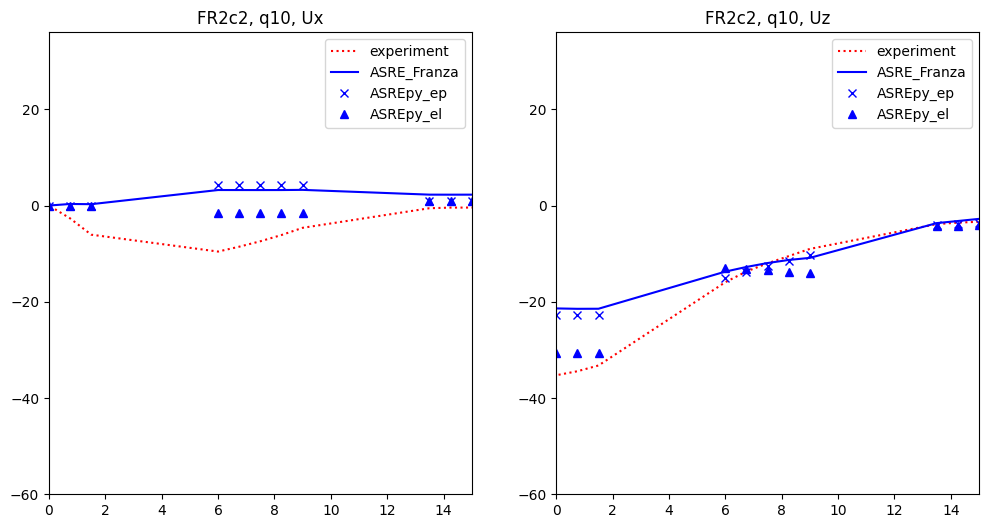

In [4]:
# Shift the coordinates by 15m to the left, this does not affect the model stiffness
footing_coord_x = footing_coord_x - 15 
# Prepare the ground deformation
vl = 2.0/100
dispX_gf, dispZ_gf = prepare_greenfield_disp(val_data_dir, vl, footing_coord_x)
Es = 25e6
nis = 0.25
mu_int = np.tan(30*np.pi/180)
qz = 10000 * self_weight_unit
footing_ele_length = ele_size_footing * np.ones_like(footing_nodes_ind).astype(float)
footing_ele_width = bfoot * np.ones_like(footing_nodes_ind).astype(float)
model = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elasto-plastic')
model_el = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elastic')
model.set_soil_properties(Es, nis, mu_int)
model_el.set_soil_properties(Es, nis, mu_int)
model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
model_el.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
                                        figsize=(12, 6))
plot_verification(val_data_dir, 'FR2c2', 'q10', model.footing_coord_x, model, axes, model_el)

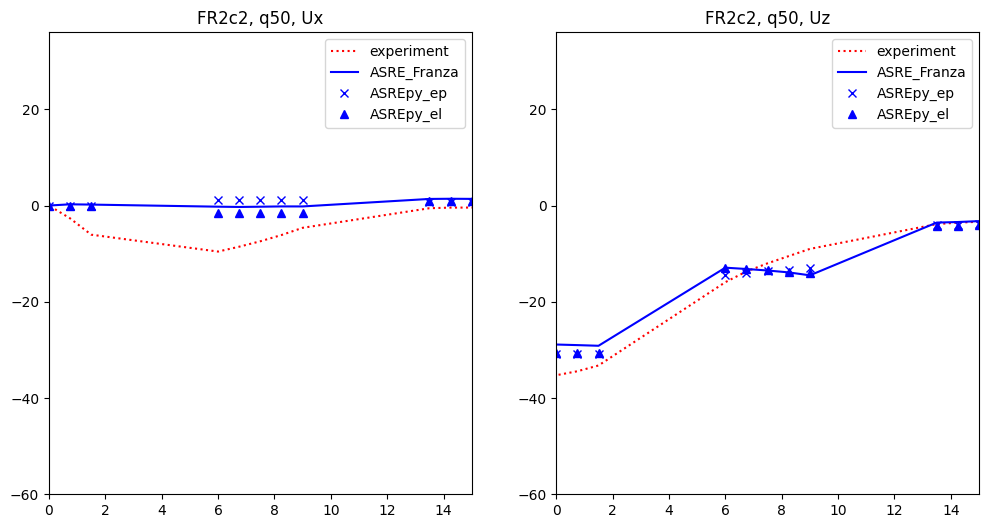

In [5]:
qz = 50000 * self_weight_unit
model = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elasto-plastic')
model_el = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elastic')
model.set_soil_properties(Es, nis, mu_int)
model_el.set_soil_properties(Es, nis, mu_int)
model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
model_el.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
                                        figsize=(12, 6))
plot_verification(val_data_dir, 'FR2c2', 'q50', model.footing_coord_x, model, axes, model_el)

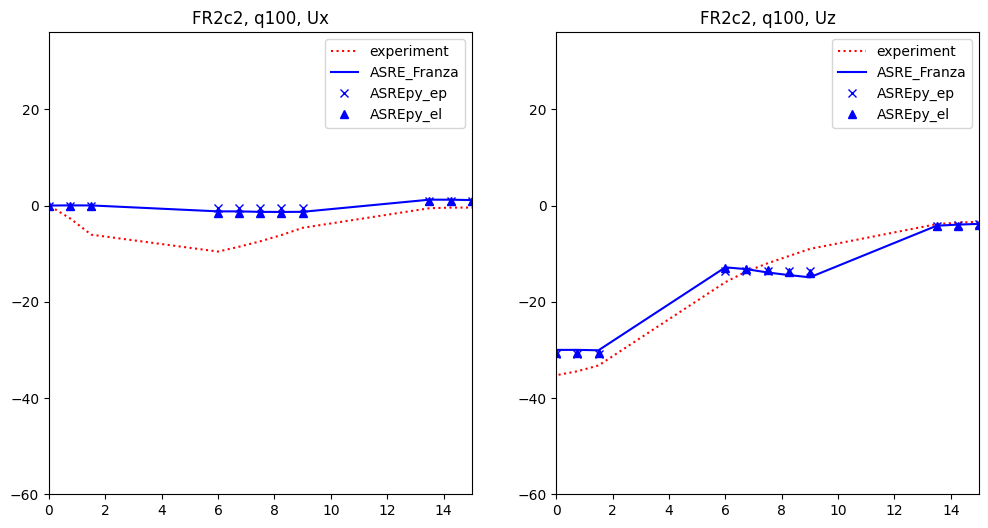

In [6]:
qz = 100000 * self_weight_unit
model = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elasto-plastic')
model_el = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elastic')
model.set_soil_properties(Es, nis, mu_int)
model_el.set_soil_properties(Es, nis, mu_int)
model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
model_el.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
                                        figsize=(12, 6))
plot_verification(val_data_dir, 'FR2c2', 'q100', model.footing_coord_x, model, axes, model_el)

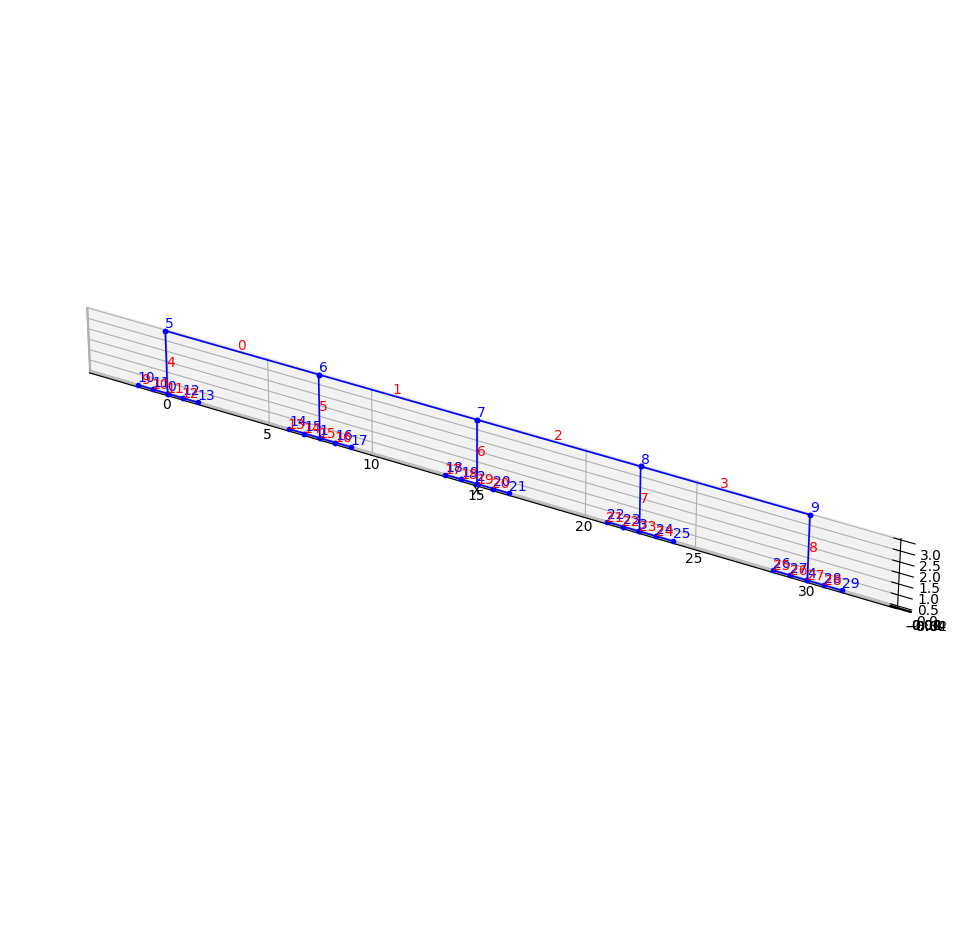

In [7]:
## Create the FR-4c4 model
beam_to_node = {}
# Clear existing model
ops.wipe()

# Define Model Builder
ops.model('basic', '-ndm', 3, '-ndf', 6)  # 3D model with 6 DOF per node

# Define parameters
n_bay = 4        # Number of bays
l_bay = 7.5      # Length of each bay
h_bay = 3.0      # Height of each story
numStories = 1  # Number of stories

# Material properties frame
b_frame = 1
d_beam = 1.5
d_column = 1.5
E = 70e9  # Young's Modulus in Pa
A_beam = b_frame * d_beam   # Area of the element in m^2
A_column = b_frame * d_column
mu = 0.28
G = E/(2*(1+mu))
Iy_beam = b_frame * d_beam**3/12
Iz_beam = d_beam**3 * b_frame/12  # Moment of Inertia in m^4
Iy_column = b_frame * d_column**3/12
Iz_column = d_column**3 * b_frame/12  # Moment of Inertia in m^4

# calculate torsional constant for beam
a = max(b_frame, d_beam)
b = min(b_frame, d_beam)
J_beam = a * b**3 / 16 * (16/3 - 3.36 * b/a * (1 - b**4/(12*a**4)))
# calculate torsional constant for column
a = max(b_frame, d_column)
b = min(b_frame, d_column)
J_column = a * b**3 / 16 * (16/3 - 3.36 * b/a * (1 - b**4/(12*a**4)))

# Material properties footing
bfoot = b_frame
dfoot = 3
E_foot = E # Young's Modulus in Pa
A_foot = bfoot * dfoot   # Area of the element in m^2
G_foot = G
Iy_foot = bfoot * dfoot**3/12
Iz_foot = dfoot**3 * bfoot/12  # Moment of Inertia in m^4
a = max(bfoot, dfoot)
b = min(bfoot, dfoot)
J_foot = a * b**3 / 16 * (16/3 - 3.36 * b/a * (1 - b**4/(12*a**4)))

# Define footing meshing parameters
num_ele_per_footing = 4 # Needs to be even
size_per_footing = 3
ele_size_footing = size_per_footing / num_ele_per_footing
num_nodes_in_frame = (n_bay + 1) * (numStories + 1)
num_elems_in_frame = n_bay * numStories + (n_bay + 1) * numStories

# Create nodes
for i in range(numStories + 1):
    for j in range(n_bay + 1):
        nodeTag = i * (n_bay + 1) + j + 0
        x = j * l_bay
        z = i * h_bay
        ops.node(nodeTag, x, 0, z)

# Define geometric transformation
horizontal_gTTag = 1
vertical_gTTag = 2
ops.geomTransf('Linear', horizontal_gTTag, 0, 0, 1)
ops.geomTransf('Linear', vertical_gTTag, 0, 1, 0)
# Define elements
for i in range(numStories):
    for j in range(n_bay):
        # Horizontal elements (beams)
        nodeI = (i + 1) * (n_bay + 1) + j + 0
        nodeJ = nodeI + 1
        eleTag = i * (n_bay) + j + 0
        ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A_beam, E, G, J_beam, Iy_beam, Iz_beam, horizontal_gTTag)
        beam_to_node[eleTag] = {'nodes':[nodeI, nodeJ],
                                'length': l_bay}

    for j in range(n_bay + 1):
        if i < numStories:
            # Vertical elements (columns)
            nodeI = i * (n_bay + 1) + j + 0
            nodeJ = nodeI + (n_bay + 1)
            eleTag = n_bay * numStories + i * (n_bay + 1) + j + 0
            ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A_column, E, G, J_column, Iy_column, Iz_column, vertical_gTTag)
# Define nodes for footing
footing_nodes_ind = []
footing_coord_x = []
footing_coord_y = []
footing_coord_z = []
for i in range(n_bay + 1):
    footing_nodes_ind_bay_i = []
    x_footing_center = i * l_bay
    x_footing_start = x_footing_center - size_per_footing / 2
    for j in range(num_ele_per_footing + 1):
        if j == num_ele_per_footing / 2:
            footing_nodes_ind.append(i)
            footing_coord_x.append(x_footing_center)
            footing_coord_y.append(0)
            footing_coord_z.append(0)
            continue
        if j < num_ele_per_footing / 2:
            nodeTag = num_nodes_in_frame + i * num_ele_per_footing + j + 0
        else:
            nodeTag = num_nodes_in_frame + i * num_ele_per_footing + j - 1
        x = x_footing_start + j * ele_size_footing
        z = 0
        ops.node(nodeTag, x, 0, z)
        footing_nodes_ind.append(nodeTag)
        footing_coord_x.append(x)
        footing_coord_y.append(0)
        footing_coord_z.append(z)
    
# Define elements for footing   
for i in range(n_bay + 1):
    for j in range(num_ele_per_footing):
        if j < num_ele_per_footing / 2 - 1:
            nodeI = num_nodes_in_frame + i * num_ele_per_footing + j
            nodeJ = nodeI + 1
        elif j == num_ele_per_footing / 2 - 1:
            nodeI = num_nodes_in_frame + i * num_ele_per_footing + j + 0
            nodeJ = i
        elif j == num_ele_per_footing / 2:
            nodeI = i
            nodeJ = num_nodes_in_frame + i * num_ele_per_footing + j + 0
        else:
            nodeI = num_nodes_in_frame + i * num_ele_per_footing + j - 1
            nodeJ = nodeI + 1
        eleTag = num_elems_in_frame + i * num_ele_per_footing + j + 0
        ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A_foot, E_foot, G_foot, J_foot, Iy_foot, Iz_foot, horizontal_gTTag)

footing_nodes_ind = np.array(footing_nodes_ind).astype(int)
footing_coord_x = np.array(footing_coord_x).astype(float)
footing_coord_y = np.array(footing_coord_y).astype(float)
footing_coord_z = np.array(footing_coord_z).astype(float)

# Calculate the self weight loads (simplified as point loads, needs refinement)
num_of_nodes = num_nodes_in_frame + len(footing_nodes_ind) - (n_bay + 1)
self_weight_unit = np.zeros(num_of_nodes * 6).astype(float)
for _, nodes in beam_to_node.items():
    nodeI = nodes['nodes'][0]
    nodeJ = nodes['nodes'][1]
    length = nodes['length']
    self_weight_unit[nodeI * 6 + 2] += (-1/2*length)
    self_weight_unit[nodeJ * 6 + 2] += (-1/2*length)

# Define the time series
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

# Define the constraint method
ops.constraints("Plain")

opsv.plot_model(element_labels=1, fig_wi_he = (50,30), local_axes=0);

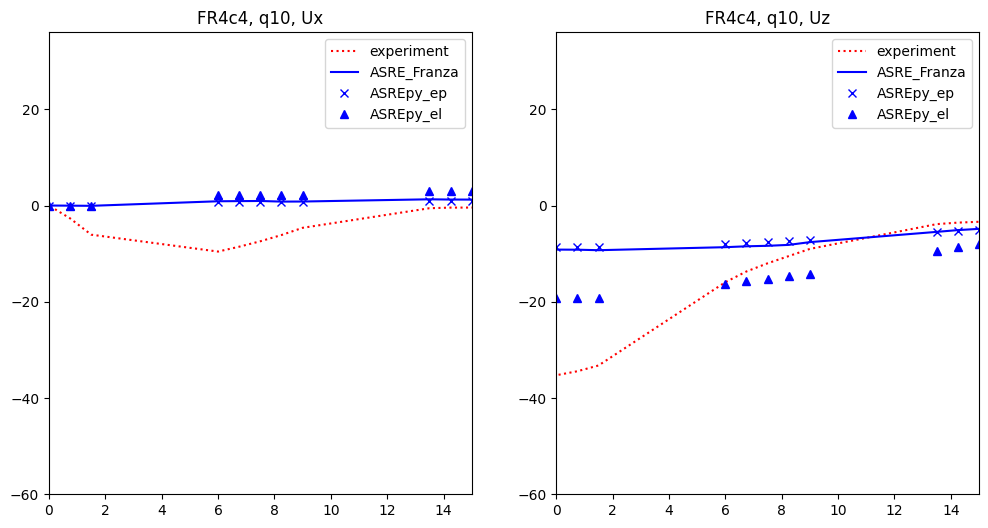

In [8]:
# Shift the coordinates by 15m to the left, this does not affect the model stiffness
footing_coord_x = footing_coord_x - 15 
# Prepare the ground deformation
vl = 2.0/100
dispX_gf, dispZ_gf = prepare_greenfield_disp(val_data_dir, vl, footing_coord_x)
Es = 25e6
nis = 0.25
mu_int = np.tan(30*np.pi/180)
qz = 10000 * self_weight_unit
footing_ele_length = ele_size_footing * np.ones_like(footing_nodes_ind).astype(float)
footing_ele_width = bfoot * np.ones_like(footing_nodes_ind).astype(float)
model = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elasto-plastic')
model_el = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elastic')
model.set_soil_properties(Es, nis, mu_int)
model_el.set_soil_properties(Es, nis, mu_int)
model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
model_el.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
                                        figsize=(12, 6))
plot_verification(val_data_dir, 'FR4c4', 'q10', model.footing_coord_x, model, axes, model_el)

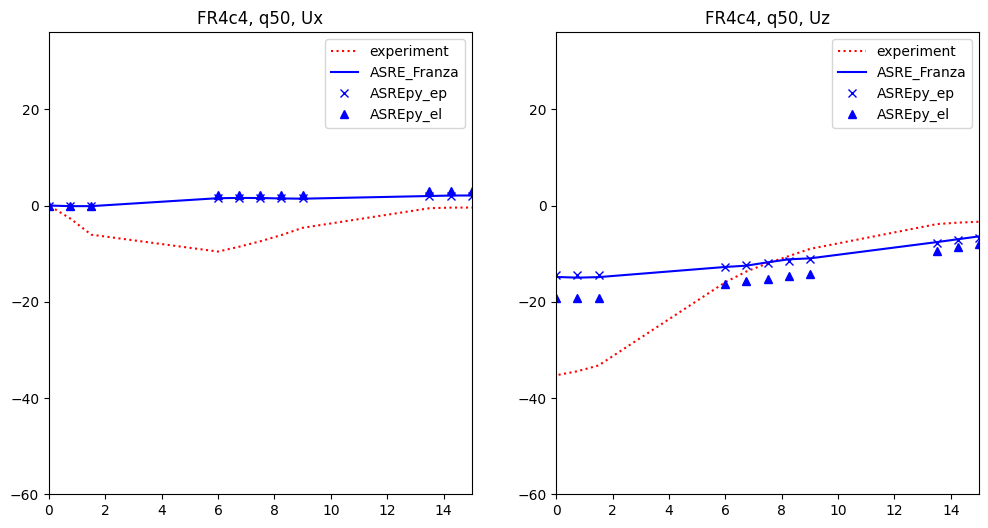

In [9]:
qz = 50000 * self_weight_unit
model = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elasto-plastic')
model_el = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elastic')
model.set_soil_properties(Es, nis, mu_int)
model_el.set_soil_properties(Es, nis, mu_int)
model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
model_el.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
                                        figsize=(12, 6))
plot_verification(val_data_dir, 'FR4c4', 'q50', model.footing_coord_x, model, axes, model_el)

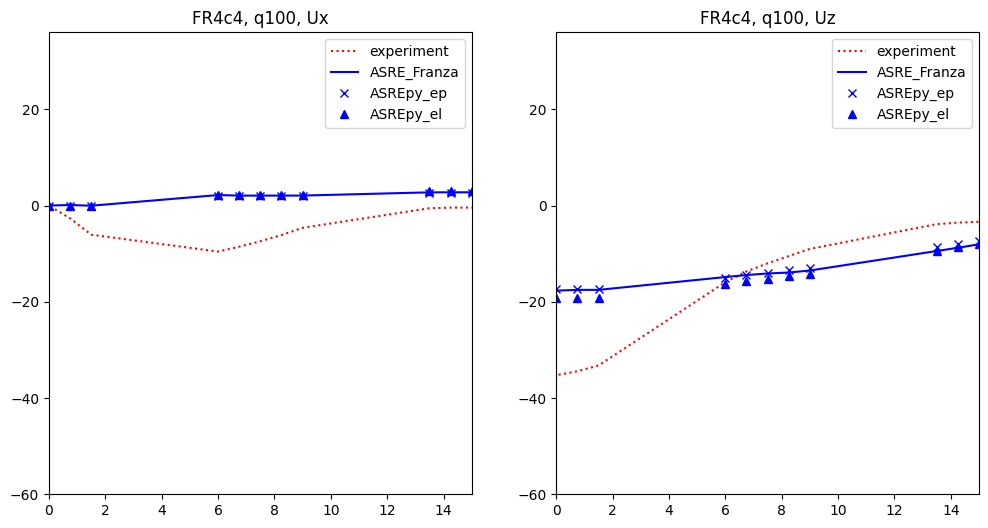

In [10]:
qz = 100000 * self_weight_unit
model = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elasto-plastic')
model_el = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elastic')
model.set_soil_properties(Es, nis, mu_int)
model_el.set_soil_properties(Es, nis, mu_int)
model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
model_el.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
                                        figsize=(12, 6))
plot_verification(val_data_dir, 'FR4c4', 'q100', model.footing_coord_x, model, axes, model_el)